In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from src.data_gen import subtraction_datasets, to_ID, to_batch
from src.endeco import Encoder, Decoder

In [2]:
embedding_dim = 200
hidden_dim = 128
vocab_size = len(to_ID())

BATCH_NUM = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
input_data, output_data = subtraction_datasets(record_num=50000)
train_x, test_x, train_y, test_y = train_test_split(input_data, output_data, train_size=0.7)
criterion = nn.CrossEntropyLoss()

In [4]:
def train(EPOCH_NUM=100, lr=0.001):
    all_losses = []
    print("training...")
    
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.001)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.001)
    
    for epoch in range(1, EPOCH_NUM + 1):
        epoch_loss = 0

        input_batch, output_batch = to_batch(train_x, train_y, batch_size=BATCH_NUM)

        for i in range(len(input_batch)):
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()

            input_ts = torch.tensor(input_batch[i], device=device)
            output_ts = torch.tensor(output_batch[i], device=device)
            #print('input_ts.shape: ', input_ts.shape)
            #torch.Size([100, 7])

            encoder_state = encoder(input_ts)
            #print(len(encoder_state))
            #2
            #print(encoder_state[0].shape, encoder_state[1].shape)
            #torch.Size([1, 100, 128]) torch.Size([1, 100, 128])

            # last-data can not be next-input.
            training_source = output_ts[:, :-1]
            # start symbol can not ba data to train.
            training_data = output_ts[:, 1:]

            #print('training_source.shape: ', training_source.shape, ', training_data.shape: ', training_data.shape)
            #training_source.shape:  torch.Size([100, 4]) , training_data.shape:  torch.Size([100, 4])
            loss = 0

            decoder_output, _ = decoder(training_source, encoder_state)
            #print(decoder_output.shape)
            #torch.Size([100, 4, 13])

            for j in range(decoder_output.size()[1]):
                loss += criterion(decoder_output[:, j, :], training_data[:, j])

            epoch_loss += loss.item()
            loss.backward()

            encoder_optimizer.step()
            decoder_optimizer.step()

        print("Epoch %d: %.2f" % (epoch, epoch_loss))
        all_losses.append(epoch_loss)
        #if epoch_loss < 1: break
    print("Done")
    
    return all_losses

In [5]:
encoder = Encoder(vocab_size, embedding_dim, hidden_dim, num_layers=1).to(device)
decoder = Decoder(vocab_size, embedding_dim, hidden_dim, num_layers=1).to(device)

# Training1
* num_layers=1

In [6]:
all_losses = train(EPOCH_NUM=100, lr=0.001)
all_losses = train(EPOCH_NUM=50, lr=0.0005)

training...
Epoch 1: 1903.82
Epoch 2: 1400.08
Epoch 3: 1207.91
Epoch 4: 1066.66
Epoch 5: 955.46
Epoch 6: 851.73
Epoch 7: 757.49
Epoch 8: 677.18
Epoch 9: 604.25
Epoch 10: 537.07
Epoch 11: 480.64
Epoch 12: 436.96
Epoch 13: 392.02
Epoch 14: 369.62
Epoch 15: 341.04
Epoch 16: 314.54
Epoch 17: 295.32
Epoch 18: 277.25
Epoch 19: 262.52
Epoch 20: 252.10
Epoch 21: 236.35
Epoch 22: 222.41
Epoch 23: 212.56
Epoch 24: 200.69
Epoch 25: 194.68
Epoch 26: 189.10
Epoch 27: 174.65
Epoch 28: 170.15
Epoch 29: 167.32
Epoch 30: 159.36
Epoch 31: 154.49
Epoch 32: 140.44
Epoch 33: 142.21
Epoch 34: 137.46
Epoch 35: 131.87
Epoch 36: 121.88
Epoch 37: 120.37
Epoch 38: 120.68
Epoch 39: 113.36
Epoch 40: 108.47
Epoch 41: 106.55
Epoch 42: 107.89
Epoch 43: 97.63
Epoch 44: 95.88
Epoch 45: 83.25
Epoch 46: 87.42
Epoch 47: 88.68
Epoch 48: 99.94
Epoch 49: 75.45
Epoch 50: 68.78
Epoch 51: 73.11
Epoch 52: 71.64
Epoch 53: 72.24
Epoch 54: 69.56
Epoch 55: 67.98
Epoch 56: 60.59
Epoch 57: 68.76
Epoch 58: 59.20
Epoch 59: 47.46
Epoch 6

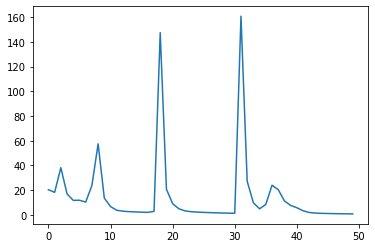

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(all_losses)

# Prediction1

In [8]:
def get_max_index(decoder_output):
    #print('get_max_index: decoder_output.shape: ', decoder_output.shape)
    #torch.Size([100, 13])
    
    results = []
    for h in decoder_output:
        #print(torch.argmax(h).shape)
        #torch.Size([])
        #print(torch.argmax(h))
        #tensor(11, device='cuda:0')

        results.append(torch.argmax(h))
        
    results = torch.tensor(results, device=device).view(BATCH_NUM, 1)
    #print(results.shape)
    #torch.Size([100, 1])
    return results

In [9]:
test_input_batch, test_output_batch = to_batch(test_x, test_y)
input_tensor = torch.tensor(test_input_batch, device=device)

predicts = []
for i in range(len(test_input_batch)):
    with torch.no_grad(): 
        encoder_state = encoder(input_tensor[i])

        # Add start symbol.
        start_char_batch = [[to_ID()["_"]] for _ in range(BATCH_NUM)]
        decoder_input_tensor = torch.tensor(start_char_batch, device=device)

        decoder_hidden = encoder_state

        # store prediction.
        batch_tmp = torch.zeros(100,1, dtype=torch.long, device=device)
        # print(batch_tmp.size())
        # (100,1)

        for _ in range(5):
            decoder_output, decoder_hidden = decoder(decoder_input_tensor, decoder_hidden)
            #print('decoder_output.shape: ', decoder_output.shape)
            #decoder_output.shape:  torch.Size([100, 1, 13])

            # output(predicted character) will be next input.
            decoder_input_tensor = get_max_index(decoder_output.squeeze())
        
            batch_tmp = torch.cat([batch_tmp, decoder_input_tensor], dim=1)

            # remove head element.
            #print('batch_tmp[:, 1:]: ', batch_tmp[:, 1:])
            #batch_tmp[:, 1:]:  tensor([[11],
        predicts.append(batch_tmp[:,1:])

print(len(predicts))
# 150
print(predicts[0].size())
# (100, 5)

150
torch.Size([100, 5])


In [10]:
import pandas as pd
id2char = {str(i) : str(i) for i in range(10)}
id2char.update({"10":"", "11":"-", "12":""})
row = []
for i in range(len(test_input_batch)):
    batch_input = test_input_batch[i]
    batch_output = test_output_batch[i]
    batch_predict = predicts[i]
    for inp, output, predict in zip(batch_input, batch_output, batch_predict):
        x = [id2char[str(idx)] for idx in inp]
        y = [id2char[str(idx)] for idx in output]
        p = [id2char[str(idx.item())] for idx in predict]

        x_str = "".join(x)
        y_str = "".join(y)
        p_str = "".join(p)

        judge = "O" if y_str == p_str else "X"
        row.append([x_str, y_str, p_str, judge])
        
predict_df = pd.DataFrame(row, columns=["input", "answer", "predict", "judge"])

# accuracy
print(len(predict_df.query('judge == "O"')) / len(predict_df))
# show wrong predictions.
print(predict_df.query('judge == "X"').head(10))

0.8668
      input answer predict judge
3   788-159    629     621     X
10  931-468    463     473     X
18  800-769     31      41     X
39  565-792   -227    -237     X
45    2-519   -517   -5177     X
49   91-979   -888    -898     X
51   66-748   -682    -692     X
72   771-56    715     725     X
73   674-44    630     640     X
76   96-587   -491    -481     X


# Training2
* num_layers=3

In [11]:
encoder = Encoder(vocab_size, embedding_dim, hidden_dim, num_layers=3).to(device)
decoder = Decoder(vocab_size, embedding_dim, hidden_dim, num_layers=3).to(device)

In [12]:
all_losses = train(EPOCH_NUM=100, lr=0.001)

training...
Epoch 1: 1895.46
Epoch 2: 1385.71
Epoch 3: 1185.40
Epoch 4: 1052.73
Epoch 5: 952.63
Epoch 6: 867.59
Epoch 7: 782.54
Epoch 8: 708.99
Epoch 9: 649.54
Epoch 10: 593.79
Epoch 11: 545.48
Epoch 12: 502.33
Epoch 13: 461.39
Epoch 14: 430.47
Epoch 15: 393.76
Epoch 16: 370.62
Epoch 17: 346.15
Epoch 18: 319.33
Epoch 19: 297.14
Epoch 20: 280.69
Epoch 21: 268.00
Epoch 22: 253.47
Epoch 23: 239.29
Epoch 24: 226.34
Epoch 25: 215.35
Epoch 26: 204.12
Epoch 27: 198.07
Epoch 28: 191.51
Epoch 29: 179.63
Epoch 30: 176.41
Epoch 31: 165.85
Epoch 32: 162.45
Epoch 33: 158.61
Epoch 34: 153.73
Epoch 35: 140.52
Epoch 36: 140.55
Epoch 37: 128.87
Epoch 38: 130.43
Epoch 39: 128.17
Epoch 40: 118.90
Epoch 41: 118.46
Epoch 42: 115.25
Epoch 43: 112.30
Epoch 44: 105.26
Epoch 45: 105.50
Epoch 46: 104.45
Epoch 47: 90.56
Epoch 48: 92.33
Epoch 49: 101.00
Epoch 50: 89.61
Epoch 51: 84.16
Epoch 52: 81.66
Epoch 53: 80.05
Epoch 54: 87.71
Epoch 55: 81.29
Epoch 56: 72.12
Epoch 57: 66.28
Epoch 58: 66.33
Epoch 59: 71.00
Ep

In [18]:
all_losses = train(EPOCH_NUM=10, lr=0.0001)

training...
Epoch 1: 61.96
Epoch 2: 8.34
Epoch 3: 4.02
Epoch 4: 3.40
Epoch 5: 60.34
Epoch 6: 28.82
Epoch 7: 6.74
Epoch 8: 3.16
Epoch 9: 2.41
Epoch 10: 1.79
Done


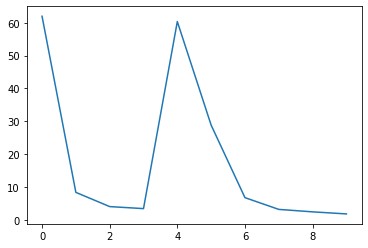

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(all_losses)

# Prediction2

In [20]:
test_input_batch, test_output_batch = to_batch(test_x, test_y)
input_tensor = torch.tensor(test_input_batch, device=device)

predicts = []
for i in range(len(test_input_batch)):
    with torch.no_grad(): 
        encoder_state = encoder(input_tensor[i])

        # Add start symbol.
        start_char_batch = [[to_ID()["_"]] for _ in range(BATCH_NUM)]
        decoder_input_tensor = torch.tensor(start_char_batch, device=device)

        decoder_hidden = encoder_state

        # store prediction.
        batch_tmp = torch.zeros(100,1, dtype=torch.long, device=device)
        # print(batch_tmp.size())
        # (100,1)

        for _ in range(5):
            decoder_output, decoder_hidden = decoder(decoder_input_tensor, decoder_hidden)
            #print('decoder_output.shape: ', decoder_output.shape)
            #decoder_output.shape:  torch.Size([100, 1, 13])

            # output(predicted character) will be next input.
            decoder_input_tensor = get_max_index(decoder_output.squeeze())
        
            batch_tmp = torch.cat([batch_tmp, decoder_input_tensor], dim=1)

            # remove head element.
            #print('batch_tmp[:, 1:]: ', batch_tmp[:, 1:])
            #batch_tmp[:, 1:]:  tensor([[11],
        predicts.append(batch_tmp[:,1:])

print(len(predicts))
# 150
print(predicts[0].size())
# (100, 5)

150
torch.Size([100, 5])


In [21]:
import pandas as pd
id2char = {str(i) : str(i) for i in range(10)}
id2char.update({"10":"", "11":"-", "12":""})
row = []
for i in range(len(test_input_batch)):
    batch_input = test_input_batch[i]
    batch_output = test_output_batch[i]
    batch_predict = predicts[i]
    for inp, output, predict in zip(batch_input, batch_output, batch_predict):
        x = [id2char[str(idx)] for idx in inp]
        y = [id2char[str(idx)] for idx in output]
        p = [id2char[str(idx.item())] for idx in predict]

        x_str = "".join(x)
        y_str = "".join(y)
        p_str = "".join(p)

        judge = "O" if y_str == p_str else "X"
        row.append([x_str, y_str, p_str, judge])
        
predict_df = pd.DataFrame(row, columns=["input", "answer", "predict", "judge"])

# accuracy
print(len(predict_df.query('judge == "O"')) / len(predict_df))
# show wrong predictions.
print(predict_df.query('judge == "X"').head(10))

0.8539333333333333
      input answer predict judge
0   612-115    497     499     X
11  663-647     16       6     X
14   76-951   -875    -865     X
23  310-372    -62     -52     X
30    2-764   -762   -7622     X
40   47-697   -650   -6400     X
46  113-564   -451    -431     X
49   261-24    237     227     X
57   47-951   -904    -894     X
58   354-90    264     254     X
